In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import statistics
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, l, f
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import pylab as py
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
import math
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import dice_ml
from dice_ml import Dice

### All features EDA

The data loaded is from the data_pipeline file

In [2]:
X = pd.read_csv("extracted_data/training_features.csv")
y = pd.read_csv("extracted_data/training_response.csv")
X['log_time'] = np.log(X['Time_Used'])
feature_names = X.columns.to_list()

Correlation heatmap

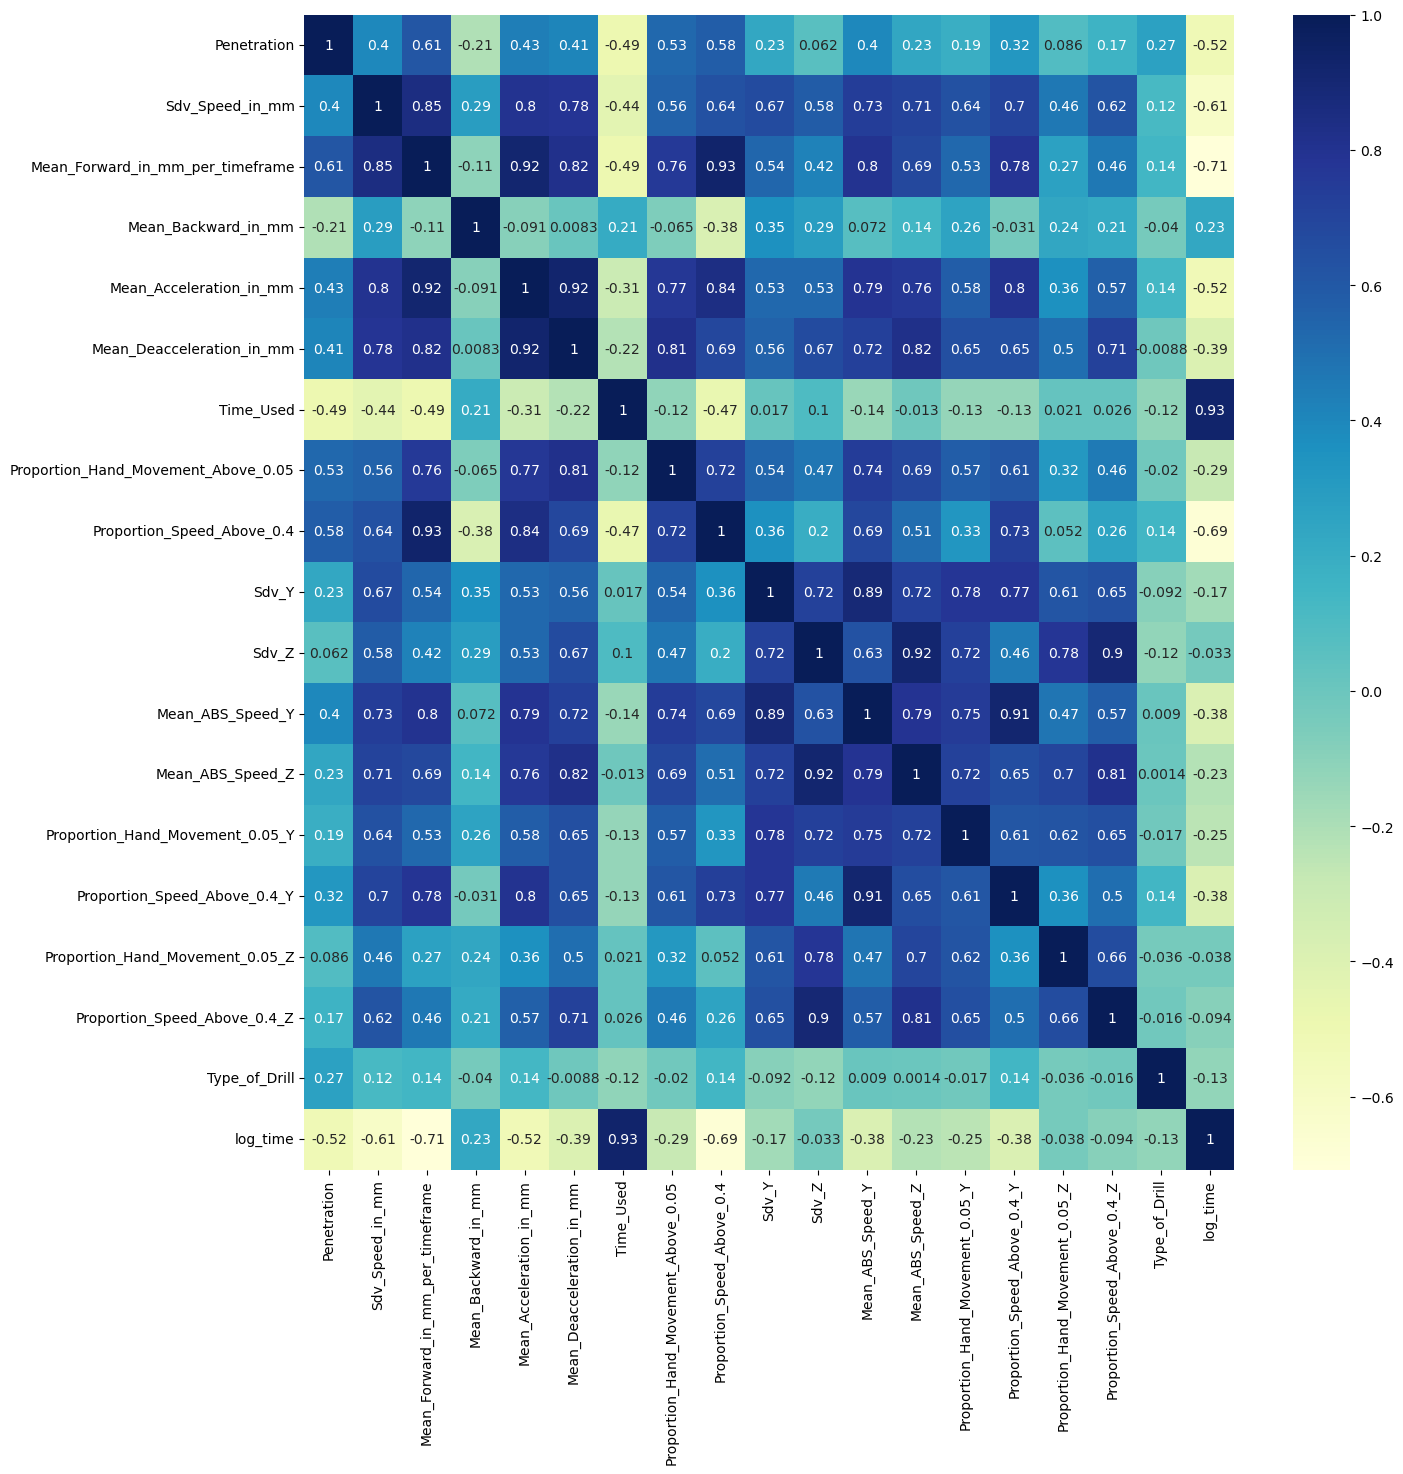

In [3]:
fig, ax = plt.subplots(figsize=(15,15))
dataplot = sns.heatmap(pd.concat([y,X], axis=1).corr(), cmap="YlGnBu", annot=True)

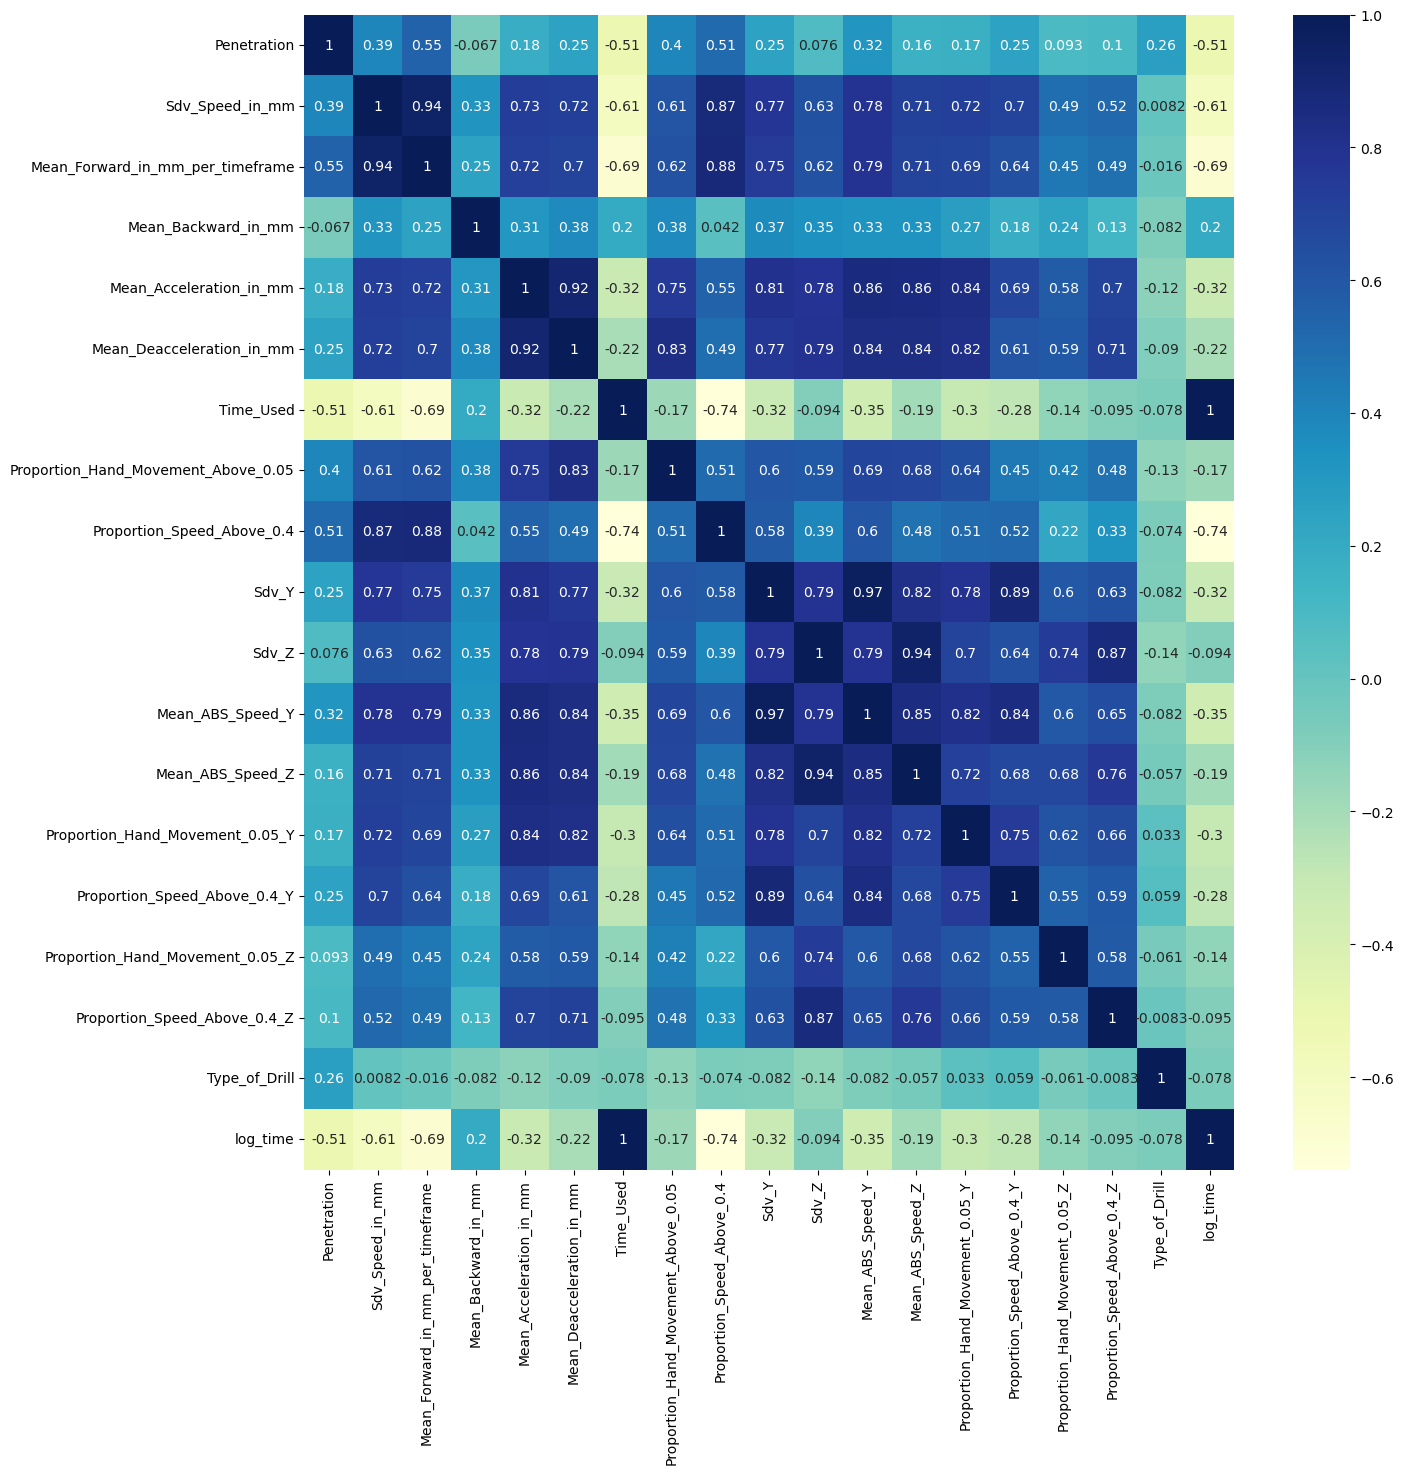

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
dataplot = sns.heatmap(pd.concat([y,X], axis=1).corr(method = "spearman"), cmap="YlGnBu", annot=True)

Distribution of the response

Text(0, 0.5, 'Counts')

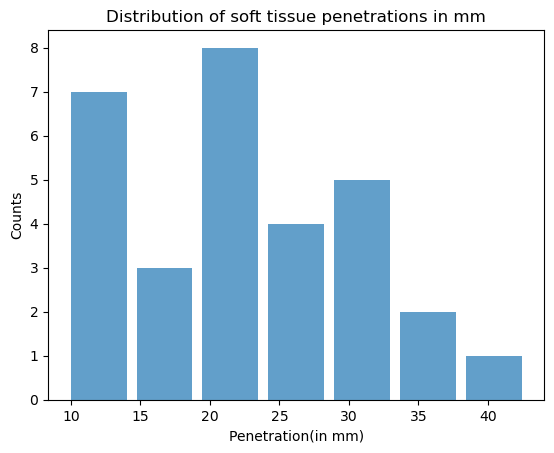

In [5]:
plt.hist(y,bins=7, alpha=0.7,rwidth=0.85)
plt.title('Distribution of soft tissue penetrations in mm')
plt.xlabel('Penetration(in mm)')
plt.ylabel('Counts')

Distribution of some highly correlated features

Text(0.02, 0.5, 'response')

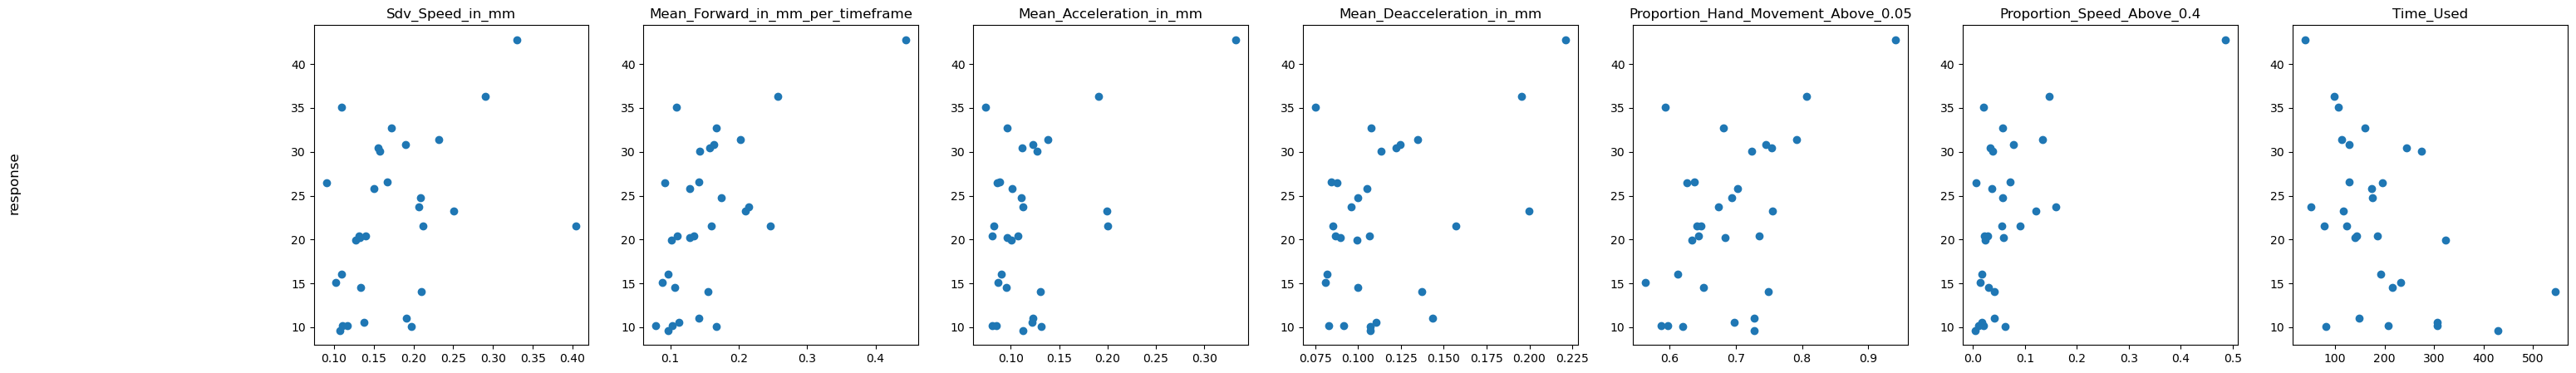

In [6]:
feature_names_visualization = ['Sdv_Speed_in_mm', 'Mean_Forward_in_mm_per_timeframe',
       'Mean_Acceleration_in_mm', 'Mean_Deacceleration_in_mm',
       'Proportion_Hand_Movement_Above_0.05',
       'Proportion_Speed_Above_0.4', 'Time_Used']
np_selected_type_drill = X[feature_names_visualization]
fig, axs = plt.subplots(1,len(feature_names_visualization), figsize=(35,5))
titles = feature_names_visualization
for i, ax in enumerate(axs):
    ax.scatter(np_selected_type_drill[feature_names_visualization[i]],y)
    ax.set_title(titles[i])
fig.supylabel('response')

### Feature Selection

Using select K best, foward sequence selector with lasso, and manual feature selection.

In [7]:
y = y.to_numpy()
k_best_selector = SelectKBest(r_regression, k=5)
selected_X_rreg = k_best_selector.fit_transform(X, y)
selected_features_k_best = k_best_selector.get_feature_names_out(feature_names)
print(selected_features_k_best)

['Mean_Forward_in_mm_per_timeframe' 'Mean_Acceleration_in_mm'
 'Mean_Deacceleration_in_mm' 'Proportion_Hand_Movement_Above_0.05'
 'Proportion_Speed_Above_0.4']


c:\Users\liule\anaconda3\envs\behavior_analysis\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.02, 0.5, 'response')

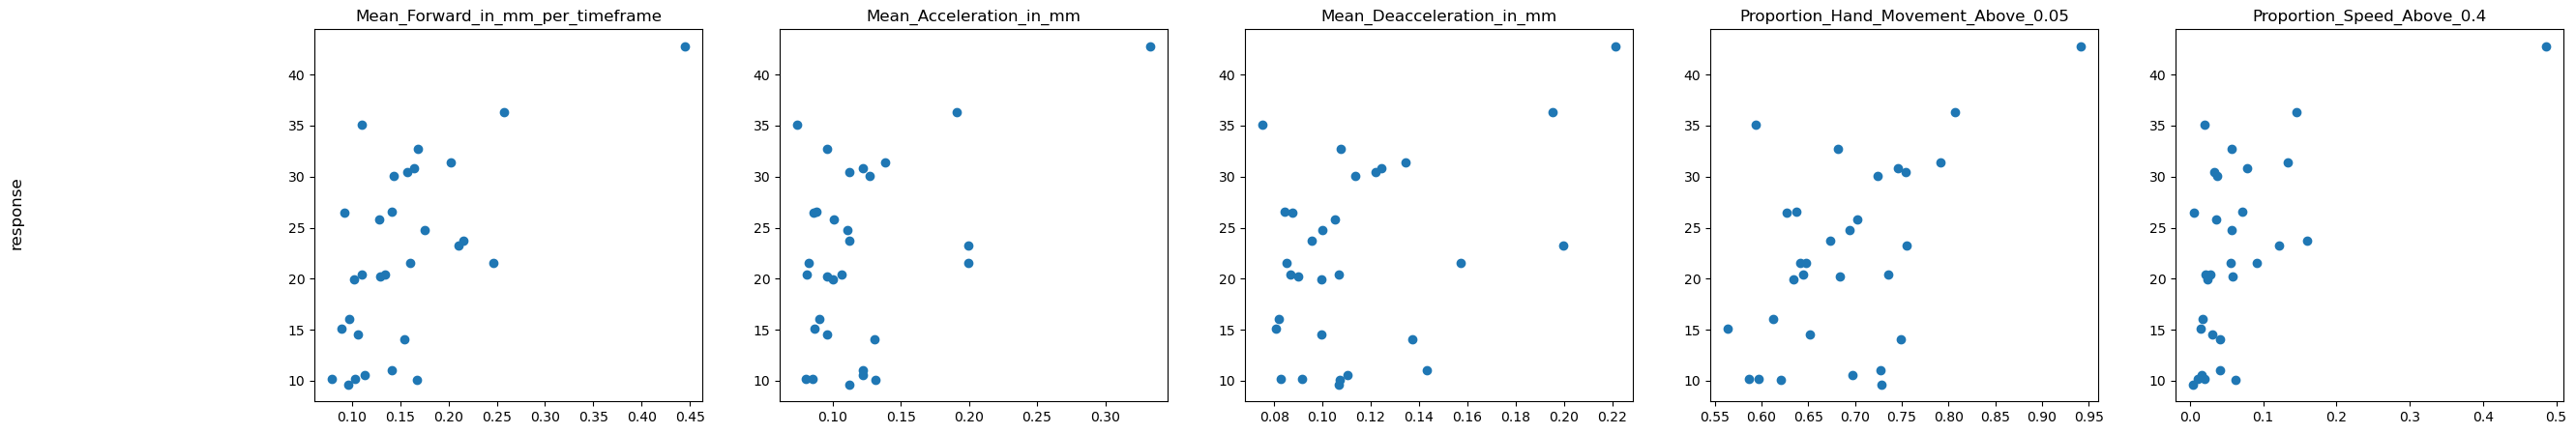

In [7]:
feature_names_visualization = selected_features_k_best
np_selected_type_drill = X[feature_names_visualization]
fig, axs = plt.subplots(1,len(feature_names_visualization), figsize=(30,5))
titles = feature_names_visualization
for i, ax in enumerate(axs):
    ax.scatter(np_selected_type_drill[feature_names_visualization[i]],y)
    ax.set_title(titles[i])
fig.supylabel('response')

In [8]:
sequentialSelector = SequentialFeatureSelector(Lasso(1), n_features_to_select=5)
selected_X_forward = sequentialSelector.fit_transform(X, y)
forward_selected_features = sequentialSelector.get_feature_names_out(feature_names)

print(forward_selected_features)

['Sdv_Speed_in_mm' 'Mean_Forward_in_mm_per_timeframe'
 'Mean_Backward_in_mm' 'Time_Used' 'Type_of_Drill']


Text(0.02, 0.5, 'response')

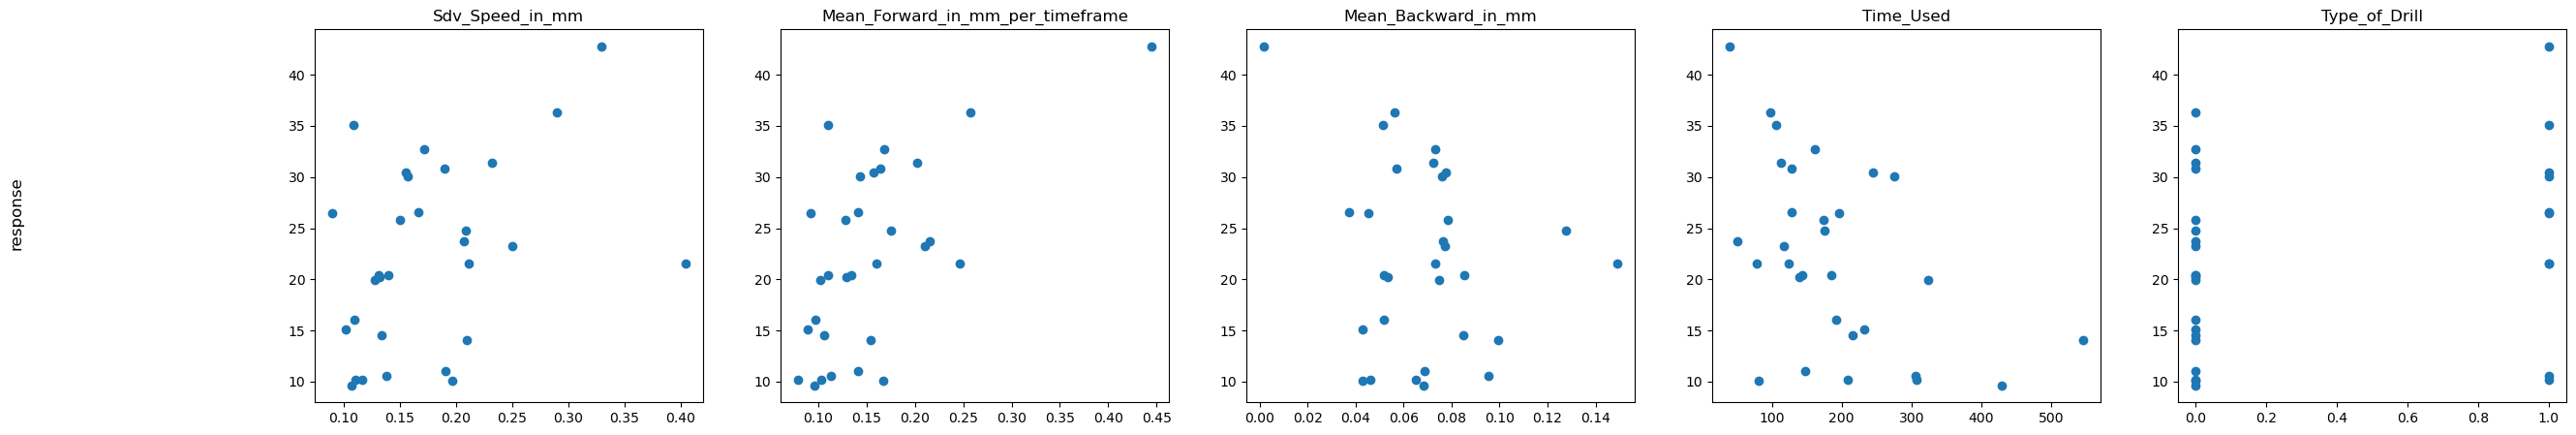

In [9]:
feature_names_visualization = forward_selected_features
np_selected_type_drill = X[feature_names_visualization]
fig, axs = plt.subplots(1,len(feature_names_visualization), figsize=(30,5))
titles = feature_names_visualization
for i, ax in enumerate(axs):
    ax.scatter(np_selected_type_drill[feature_names_visualization[i]],y)
    ax.set_title(titles[i])
fig.supylabel('response')

### GAM models

GAM models are used to select importance features for the surgeon performance.

#### Base model

Use the feature that is most correlated to soft tissue penetration. This model is just a simple linear regression model.

In [10]:
Mean_Forward_in_mm_per_timeframe = X["Mean_Forward_in_mm_per_timeframe"]
gam_base = LinearGAM(l(0))
gam_base.fit(Mean_Forward_in_mm_per_timeframe, y)
gam_base.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       1.199
Link Function:                     IdentityLink Log Likelihood:                                  -155.3398
Number of Samples:                           30 AIC:                                              315.0776
                                                AICc:                                             315.6026
                                                GCV:                                               75.6863
                                                Scale:                                             70.2614
                                                Pseudo R-Squared:                                   0.1332
Feature Function                  Lam

C:\Users\liule\AppData\Local\Temp\ipykernel_46820\21038005.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_base.summary()


Visualization for the base model

Text(0.02, 0.5, 'Change in penetration')

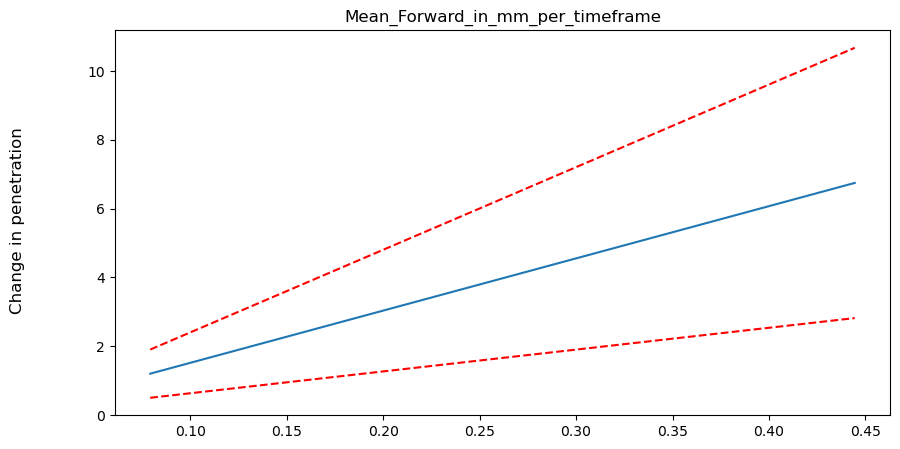

In [11]:
selected_feature_names = ["Mean_Forward_in_mm_per_timeframe"]
fig, axs = plt.subplots(1,len(selected_feature_names), figsize=(10,5))
titles = selected_feature_names
XX = gam_base.generate_X_grid(term=0)
axs.plot(XX[:, 0], gam_base.partial_dependence(term=0, X=XX))
axs.plot(XX[:, 0], gam_base.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
axs.set_title(titles[0])
fig.supylabel('Change in penetration')

MAE for the base model

In [12]:
kf = KFold(n_splits=30)
np_selected_type_drill = Mean_Forward_in_mm_per_timeframe.to_numpy()
kf.get_n_splits(np_selected_type_drill)
MAEs = []

for i, (train_index, test_index) in enumerate(kf.split(np_selected_type_drill)):
    train_X = np_selected_type_drill[train_index]
    train_y = y[train_index]
    test_X = np_selected_type_drill[test_index]
    test_y = y[test_index]
    gam_base.fit(train_X, train_y)
    predictions = gam_base.predict(test_X)
    err = np.subtract(predictions, test_y)
    abs_err = np.absolute(err)
    MAEs.append(abs_err.mean())
print("MAE of leave-one-out corss validation is: " + str(statistics.mean(MAEs)) + " in mm")

MAE of leave-one-out corss validation is: 7.188324708617623 in mm


#### First model with k best selected features

The first model is the most accurate model in validation so far, and the AIC value (288) shows that the modeling is better than the base model. However, there are counter-intuitive results. For example, from the graph, sdv should be insignificant, and the mean forward speed shows some weird trend for large values. Thus, other models are also built and tested.

In [13]:
selected_feature_names = ['Sdv_Speed_in_mm', 'Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05']

In [14]:
np_selected_type_drill = X[selected_feature_names].to_numpy()
gam_first = LinearGAM(s(0,penalties='derivative',n_splines=13) + s(1, n_splines=8) + s(2, n_splines=8)+  s(3, n_splines=5) )
gam_first.fit(np_selected_type_drill, y)
gam_first.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.6665
Link Function:                     IdentityLink Log Likelihood:                                  -134.5281
Number of Samples:                           30 AIC:                                              288.3892
                                                AICc:                                             299.0554
                                                GCV:                                               70.1578
                                                Scale:                                             34.9938
                                                Pseudo R-Squared:                                   0.6802
Feature Function                  Lam

C:\Users\liule\AppData\Local\Temp\ipykernel_46820\2959492905.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_first.summary()


Visualization for first model

Based on the partial dependence plot, it can be seen that mean forward speed and large hand movements are positively correlated to the soft tissue penetration.

The standard deviation of speed shows there might be an optimal standard deviation for speed to achieve.

The mean acceleration is a bit counter-intuitive though as it is negatively correlated to the soft tissue penetration. One explanation might be that good drills contain a lot of deaccelerations, which will lead to more accelerations; and for a bad drill, the operator might just start with a high speed and do not change a lot.

Text(0.02, 0.5, 'Change in penetration')

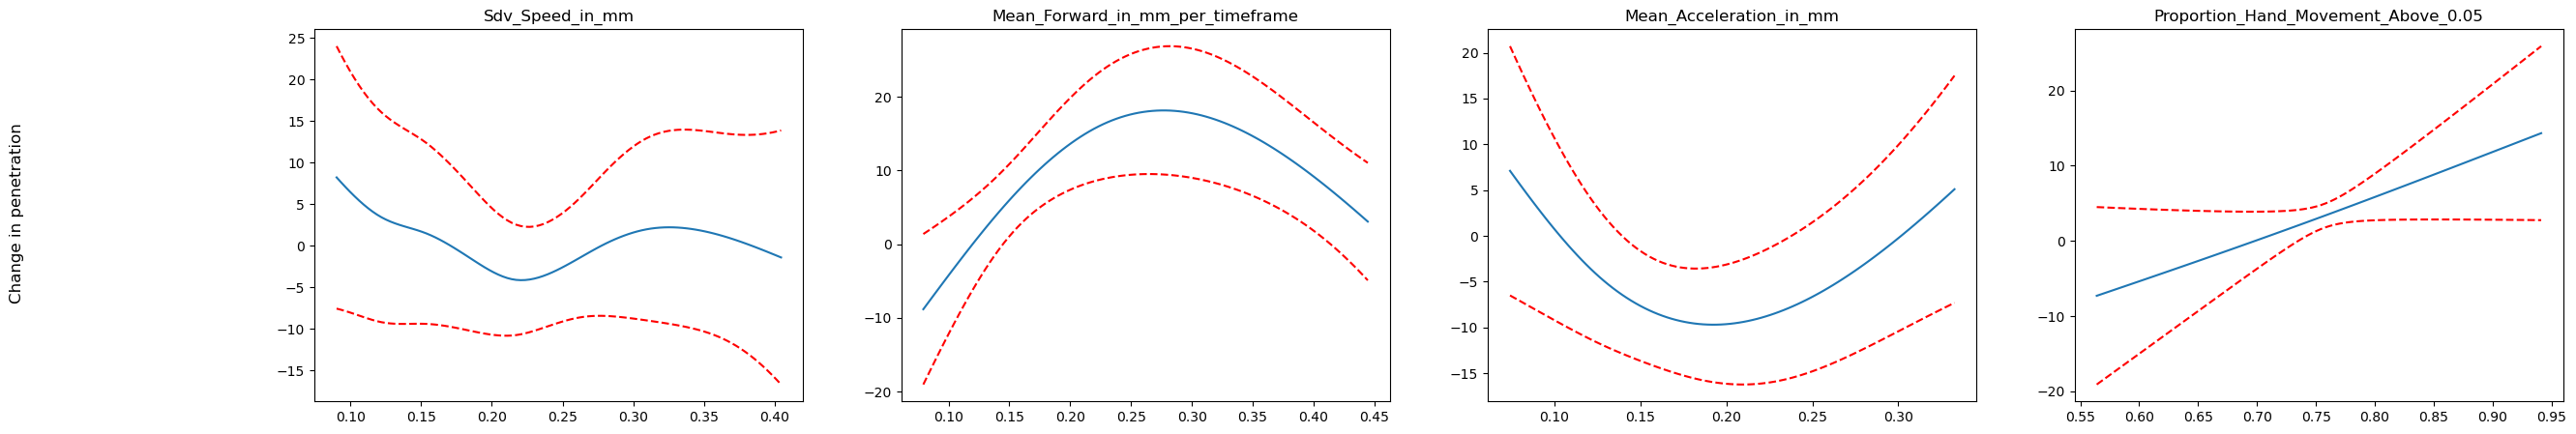

In [15]:
fig, axs = plt.subplots(1,len(selected_feature_names), figsize=(30,5))
titles = selected_feature_names
for i, ax in enumerate(axs):
    XX = gam_first.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_first.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_first.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
fig.supylabel('Change in penetration')

Accuracy for the first model based on select k best

To show whether the modelling is good or not, a leave-one-out CV evaluation is performed as well. The mean absolute error (MAE) is around 5.7 mm, which is a large improvement from MAE of 7.2 mm in the based model. However, such high accuracy in the validation set might be a sign of overfitting.

In [16]:
kf = KFold(n_splits=30)
kf.get_n_splits(np_selected_type_drill)
MAEs = []
for i, (train_index, test_index) in enumerate(kf.split(np_selected_type_drill)):
    train_X = np_selected_type_drill[train_index]
    train_y = y[train_index]
    test_X = np_selected_type_drill[test_index]
    test_y = y[test_index]
    gam_first.fit(train_X, train_y)
    predictions = gam_first.predict(test_X)
    err = np.subtract(predictions, test_y)
    abs_err = np.absolute(err)
    MAEs.append(abs_err.mean())
print("MAE of leave-one-out corss validation is: " + str(statistics.mean(MAEs)) + " in mm")

MAE of leave-one-out corss validation is: 5.722471866160682 in mm


Model validation

Model validation plots show that the model is somehow valid. To further improve, more data points will be needed.

In [17]:
gam_first.fit(np_selected_type_drill, y)
res = gam_first.deviance_residuals(np_selected_type_drill, y)
prediction_list = gam_first.predict(np_selected_type_drill)

The residual is somehow normally distributed.

Text(0, 0.5, 'Counts')

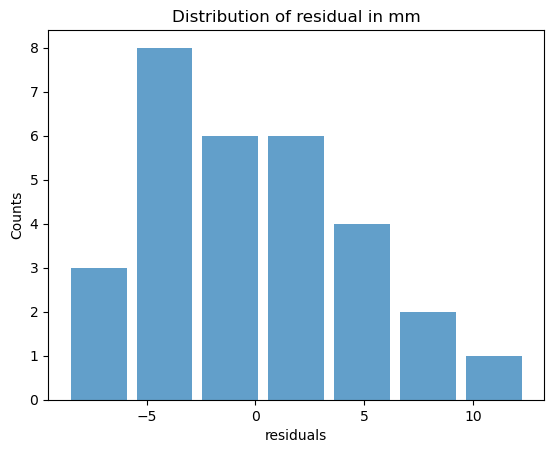

In [18]:
plt.hist(res,bins=7, alpha=0.7,rwidth=0.85)
plt.title('Distribution of residual in mm')
plt.xlabel('residuals')
plt.ylabel('Counts')

From the plot, there might be heteroscedastic error problem, but it's a bit hard to confirm due to low sample size.

Text(0, 0.5, 'residuals')

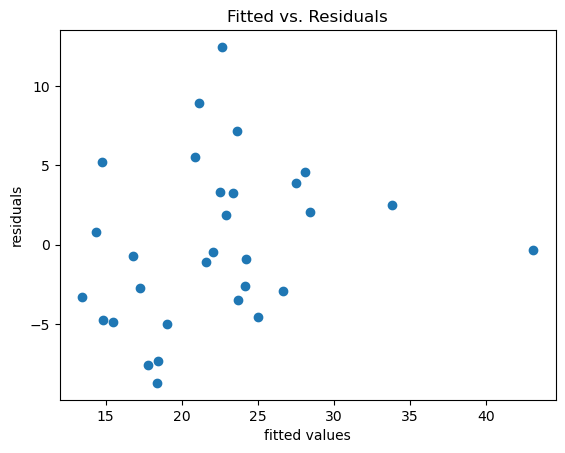

In [19]:
plt.scatter(y=res, x = prediction_list)
plt.title('Fitted vs. Residuals')
plt.xlabel('fitted values')
plt.ylabel('residuals')

The fitted value vs. response plot shows that the model is performing ok.

Text(0, 0.5, 'response')

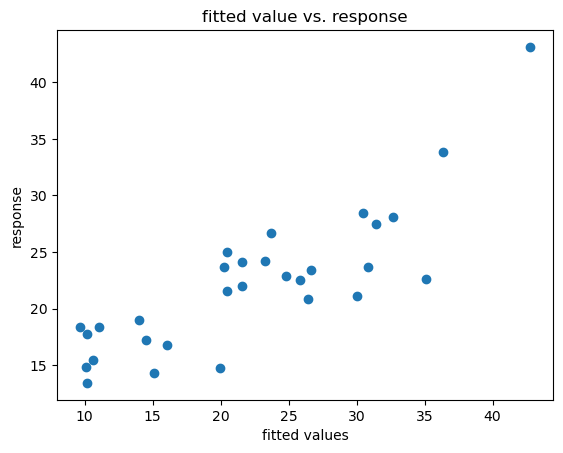

In [20]:
plt.scatter(y=prediction_list, x = y)
plt.title('fitted value vs. response')
plt.xlabel('fitted values')
plt.ylabel('response')

#### Second model with sequencial selected features as well as manual selection (final model)

Second model tries to include other features that are important in the sequential selection. In this model, time used and type of drill are added. From the result, the AIC value (292) shows that the model perfroms similar to the first model, and better than the base model. This model shows that mean forward speed, mean acceleration, proportion of large hand movements, and time spent can contribute significantly to the result. From the partial dependence plot, the features show much more reasonable trends. This model is chosen as the final model

In [21]:
selected_feature_names = ['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05', 'log_time', 'Type_of_Drill']

In [22]:
np_selected_type_drill = X[selected_feature_names].to_numpy()
gam_second = LinearGAM(s(0, n_splines=6) + s(1, n_splines=16)+  s(2, n_splines = 8) + s(3, n_splines = 5) + f(4))
gam_second.fit(np_selected_type_drill, y)
gam_second.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.9975
Link Function:                     IdentityLink Log Likelihood:                                  -137.1621
Number of Samples:                           30 AIC:                                              292.3191
                                                AICc:                                             301.3132
                                                GCV:                                               71.3647
                                                Scale:                                             38.2268
                                                Pseudo R-Squared:                                   0.6397
Feature Function                  Lam

C:\Users\liule\AppData\Local\Temp\ipykernel_46820\3669315000.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_second.summary()


Visualization of second model

The partial dependence plot shows that the speed has some diminishing return effect besides the positive correlation

Similar to the first model, this model shows that the there might be some optimal value for acceleration

This model also shows the proportion of large movements is positively correlated to the penetration, which also has diminishing return effect.

The model shows time spent is negatively correlated to the penetration.

Text(0.02, 0.5, 'Change in penetration')

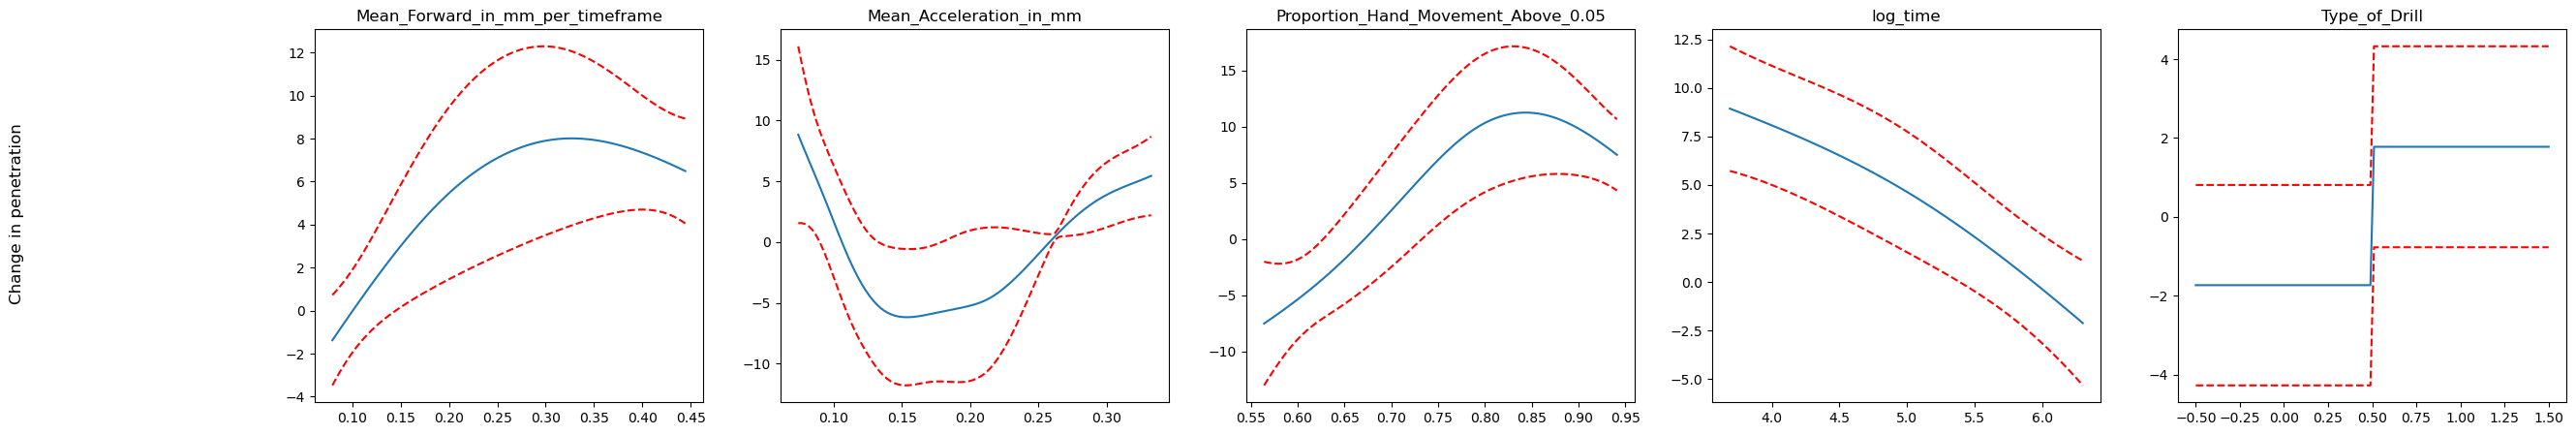

In [23]:
fig, axs = plt.subplots(1,len(selected_feature_names), figsize=(30,5))
titles = selected_feature_names
for i, ax in enumerate(axs):
    XX = gam_second.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_second.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_second.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
fig.supylabel('Change in penetration')

MAE validation

The MAE validation has result 6.8 mm for leave one out cv. This is an improvement from the base model.

In [24]:
kf = KFold(n_splits=30)
kf.get_n_splits(np_selected_type_drill)
MAEs = []
for i, (train_index, test_index) in enumerate(kf.split(np_selected_type_drill)):
    train_X = np_selected_type_drill[train_index]
    train_y = y[train_index]
    test_X = np_selected_type_drill[test_index]
    test_y = y[test_index]
    gam_second.fit(train_X, train_y)
    predictions = gam_second.predict(test_X)
    err = np.subtract(predictions, test_y)
    abs_err = np.absolute(err)
    MAEs.append(abs_err.mean())
print("MAE of leave-one-out corss validation is: " + str(statistics.mean(MAEs)) + " in mm")

MAE of leave-one-out corss validation is: 6.82307518458955 in mm


Model validation

The plots show that the model is somehow valid

In [25]:
gam_second.fit(np_selected_type_drill, y)
res = gam_second.deviance_residuals(np_selected_type_drill, y)
prediction_list = gam_second.predict(np_selected_type_drill)

The residuals are normally distributed

Text(0, 0.5, 'Counts')

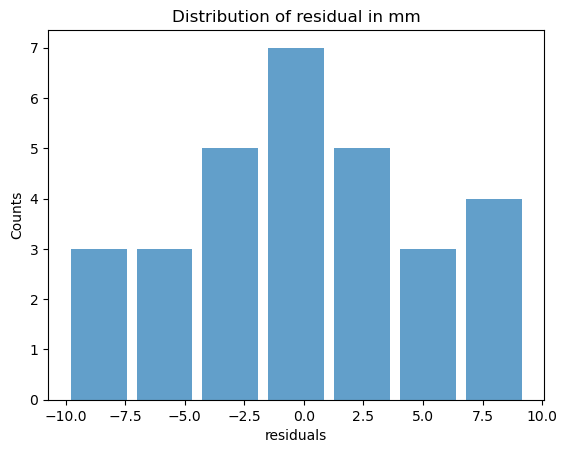

In [26]:
plt.hist(res,bins=7, alpha=0.7,rwidth=0.85)
plt.title('Distribution of residual in mm')
plt.xlabel('residuals')
plt.ylabel('Counts')

From the plot, there might not be heteroscedastic error problem, but it's a bit hard to confirm due to low sample size.

Text(0, 0.5, 'residuals')

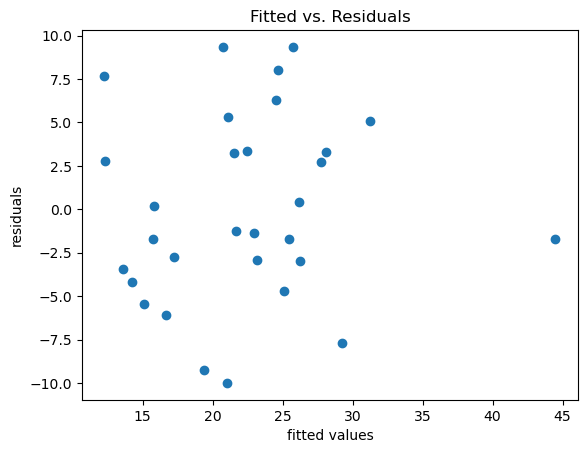

In [27]:
plt.scatter(y=res, x = prediction_list)
plt.title('Fitted vs. Residuals')
plt.xlabel('fitted values')
plt.ylabel('residuals')

The fitted value vs. response plot shows that the model is performing better than the first model.

Text(0, 0.5, 'response')

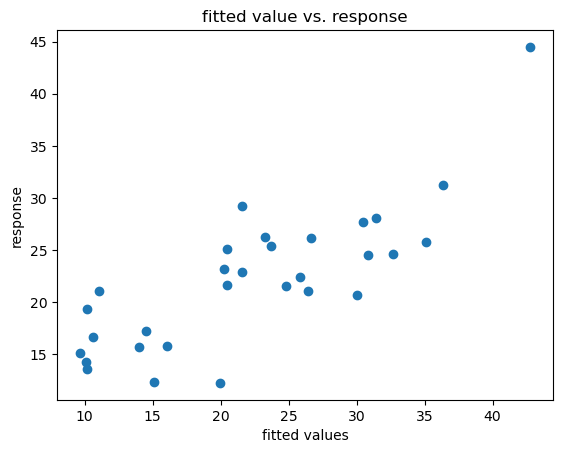

In [28]:
plt.scatter(y=prediction_list, x = y)
plt.title('fitted value vs. response')
plt.xlabel('fitted values')
plt.ylabel('response')

### EBM models

In additional to GAM models, EBM model can also explain how each feautre impact the penetration, and also show what features are influencital. 

From the result, it can be seen that the most influencial feature is the mean forward speed, and the least influencial feature is the type of drill. The plots that demonstrate how each feature impact the penetration show similar result to the partial dependence plot obtained in the final GAM model

In [29]:
selected_features = ['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05', 'log_time', 'Type_of_Drill']
ebm_training = X[selected_features]
ebm_training['Type_of_Drill'] = ebm_training['Type_of_Drill'].astype("category")
ebm = ExplainableBoostingRegressor(learning_rate= 0.001, max_leaves=32, max_rounds= 10000, feature_names = selected_features, early_stopping_rounds= 200,
                                   interactions=0,validation_size=0.4,early_stopping_tolerance=0.001,inner_bags=16,outer_bags=8,binning="rounded_quantile",max_bins=512
                                   )

scores_ebm = cross_val_score(ebm, ebm_training, y, cv=10, scoring="neg_mean_squared_error")
scores_ebm_abs = cross_val_score(ebm, ebm_training, y, cv=10, scoring="neg_mean_absolute_error")

C:\Users\liule\AppData\Local\Temp\ipykernel_46820\4069803336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebm_training['Type_of_Drill'] = ebm_training['Type_of_Drill'].astype("category")


In [30]:
root_MSE = math.sqrt(abs(scores_ebm).mean())
print("The squared root of MSE is: " + str(root_MSE))
print("The MAE is: " + str(abs(scores_ebm_abs.mean())))

The squared root of MSE is: 9.155349127857004
The MAE is: 7.66299060597859


In [31]:
ebm.fit(ebm_training, y)
show(ebm.explain_global(name="Soft_Penetration"))

<!-- http://127.0.0.1:7001/2458101754752/ -->

### Conclusion on modelling

In the end, the conclusion can be made that mean forward speed, mean acceleration, proportion of large hand movements, and time spent can be significant factors that impact soft tissue penetration. 

From the partial dependence plot of GAM models, educational insights might be aquired, and maybe students should focus on these aspects in the surgical training. 

From the result of EBM model, it shows that the most infulential feature might be the mean forward speed, while the least influential feature might be the type of drill.

Importantly, the models are based on only 30 samples. In this case, no definite conclusion can be made, only with more samples a meaningful result can be achieved.

### Counterfactual Explanations

Also, conterfactual explanation is performed using features selected. The analysis uses boosting method and aims to provide insights that what surgeons can do to improve their performance. 

One drawback of the analysis is that the package does not support GAMs and EBMs. Instead in this part, a ridge regression is built to support the counterfactual analysis. The performance of the ridge regression is similar to the GAM model built previously.

Another drawback for the conterfactual analysis is the inference time can be very long. And in this case the it would be an limitation in real-world use case.

In [32]:
selected_features = ['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05', 'log_time']
cts_features = ['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05', 'log_time']
cf_df = X[selected_features]
cf_df["Penetration"] = y

cf_df_train, cf_df_test, y_train, y_test = train_test_split(cf_df, y, test_size=1/30, random_state=42)


C:\Users\liule\AppData\Local\Temp\ipykernel_46820\4199455475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cf_df["Penetration"] = y


In [33]:
gbr = Ridge(1)
model_gbr = gbr.fit(cf_df_train.drop('Penetration', axis = 1), cf_df_train['Penetration'])

In [34]:
data_cf = dice_ml.Data(dataframe=cf_df_train, continuous_features=cts_features, outcome_name="Penetration")
# We provide the type of model as a parameter (model_type)
model_cf = dice_ml.Model(model=model_gbr, backend="sklearn", model_type='regressor')
exp= Dice(data_cf, model_cf, method="genetic")

The result shows that if the operator wants to keep the penetration between 5 mm and 15 mm, he/she needs to decrease forward speed, decrease drastic movements, and also take longer time in total.

In [35]:
query_instances = cf_df_test
generic_cf = exp.generate_counterfactuals(query_instances.drop('Penetration', axis = 1), total_CFs=1, desired_range=[5.0, 15.0], features_to_vary=cts_features)
generic_cf.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

Query instance (original outcome : 26)


,Mean_Forward_in_mm_per_timeframe,Mean_Acceleration_in_mm,Proportion_Hand_Movement_Above_0.05,log_time,Penetration
0,0.257184,0.190952,0.806818,4.584968,26.141939



Diverse Counterfactual set (new outcome: [5.0, 15.0])


,Mean_Forward_in_mm_per_timeframe,Mean_Acceleration_in_mm,Proportion_Hand_Movement_Above_0.05,log_time,Penetration
0,0.258353,0.195343,0.655364,6.287093,14.594042
